In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['heart.csv']


In [2]:
# Additional imports
import matplotlib.pyplot as plt
import seaborn as sns

# Data splitting/parameter tuning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


# ML models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Feature processing
from sklearn.feature_selection import SelectPercentile, chi2

# Evaluation metrics
from sklearn.metrics import confusion_matrix

Let's load the data and take a look

In [3]:
heart_path = "../input/heart.csv"
heart_data = pd.read_csv(heart_path)

In [4]:
heart_data.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# Description of columns

* **age:** The person's age in years
* **sex:** The person's sex (1 = male, 0 = female)
* **cp:** The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
* **trestbps:** The person's resting blood pressure (mm Hg on admission to the hospital)
* **chol:** The person's cholesterol measurement in mg/dl
* **fbs:** The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)
* **restecg:** Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
* **thalach:** The person's maximum heart rate achieved
* **exang:** Exercise induced angina (1 = yes; 0 = no)
* **oldpeak:** ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more here)
* **slope:** the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
* **ca:** The number of major vessels (0-3)
* **thal:** A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
* **target:** Heart disease (0 = no, 1 = yes)

In [5]:
print("Heart data shape is:", heart_data.shape[0], "x", heart_data.shape[1])

Heart data shape is: 303 x 14


In [6]:
# Missing values
heart_data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

# Data exploration

Let's take a deeper look at some of the features. We are going to make some visualizations to make things more obvious to us and get some insights about our data. Kaggle does a great and simply job capturing the most important things to make awesome [visualizations](https://www.kaggle.com/learn/data-visualization)

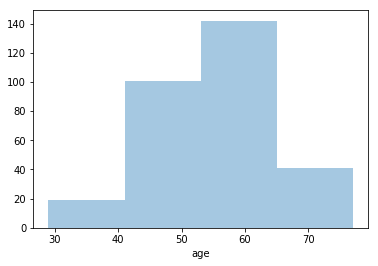

In [7]:
sns.distplot(heart_data["age"], bins=4, kde=False)

* **Approximately, 80% of the people are in the range of 41-65.**

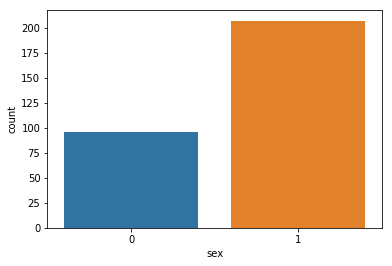

In [8]:
sns.countplot(heart_data["sex"])

* **More than 2/3 of the population in the dataset are male**

In [9]:
total = len(heart_data["sex"])
males = heart_data["sex"].sum()
females = len(heart_data["sex"]) - males
print("Porcentage of males:", round(males/total*100, 3))
print("procentage of females:", round(females/total*100, 3))

Porcentage of males: 68.317
procentage of females: 31.683


Text(0, 0.5, 'amount')

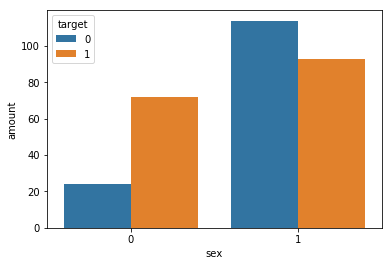

In [10]:
sex_graph = sns.countplot(heart_data["sex"], hue=heart_data["target"])
sex_graph.set_ylabel("amount")

* **There are not a huge disparity between the number of healthy and unhealthy men. The difference is more notoriuos for females.**

Text(0, 0.5, 'amount')

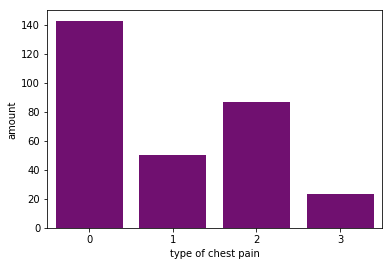

In [11]:
cp_graph = sns.countplot(heart_data["cp"], color="purple")
cp_graph.set_xlabel("type of chest pain")
cp_graph.set_ylabel("amount")

* **Almost, half of the people are asymptomatic.**

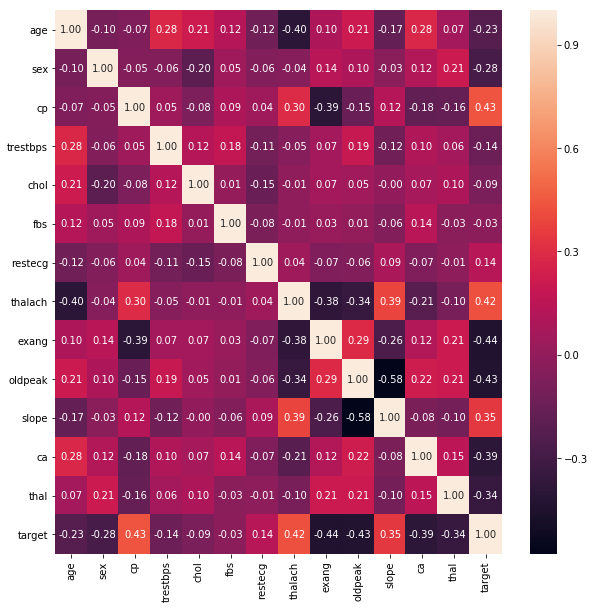

In [12]:
plt.figure(figsize=(10, 10))
sns.heatmap(heart_data.corr(), annot=True, fmt='.2f')

* **A summary of the correlation of every pair of features. The ones that are more correlated with the target are cp, thalach and slop in that order. This is a good way to later select the most promising features for our final model, although there are other more sophisticated and automated ways to select the best features.**

# Preprocessing data

In [13]:
heart_data.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

Due to the description of the features, some of them are categorical not numbers, so let's fix that.

In [14]:
heart_data['sex'] = heart_data['sex'].astype('object')
heart_data['cp'] = heart_data['cp'].astype('object')
heart_data['fbs'] = heart_data['fbs'].astype('object')
heart_data['restecg'] = heart_data['restecg'].astype('object')
heart_data['exang'] = heart_data['exang'].astype('object')
heart_data['slope'] = heart_data['slope'].astype('object')
heart_data['thal'] = heart_data['thal'].astype('object')

In [15]:
heart_data.dtypes

age           int64
sex          object
cp           object
trestbps      int64
chol          int64
fbs          object
restecg      object
thalach       int64
exang        object
oldpeak     float64
slope        object
ca            int64
thal         object
target        int64
dtype: object

A very important step to apply is to one-hot encode categorical features. Allowing us to use these features properly.

In [16]:
heart_data = pd.get_dummies(heart_data)
heart_data.head()

,age,trestbps,chol,thalach,oldpeak,ca,target,sex_0,sex_1,cp_0,cp_1,cp_2,cp_3,fbs_0,fbs_1,restecg_0,restecg_1,restecg_2,exang_0,exang_1,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,thal_3
0,63,145,233,150,2.3,0,1,0,1,0,0,0,1,0,1,1,0,0,1,0,1,0,0,0,1,0,0
1,37,130,250,187,3.5,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0
2,41,130,204,172,1.4,0,1,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0
3,56,120,236,178,0.8,0,1,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0
4,57,120,354,163,0.6,0,1,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0


In [17]:
print("Heart data shape is:", heart_data.shape[0], "x", heart_data.shape[1])

Heart data shape is: 303 x 27


# Machine learning

Let's try some models to see their performance. Due to the fact that is a small dataset, we are going to use cross_validation rather than the usual train_test_split. To evaluate our models we will use "recall".

**We are using a health dataset and exist a high cost associated with False Negative (people with heart desease with the wrong diagnosis). That is the main number we want to minimize, and recall captures exactly what we want. This is the ecuation for recall:**

**Recall = True Positive / (True Positive + False Negative)**

More information on evaluation metric could be found [here](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9).

In [18]:
# Getting features and target
X = heart_data.drop(["target"], axis=1)
y = heart_data["target"]

Let's do a quick round with multiple machine learning models, and see  what are the most promising.
To each model we will print the **confusion matrix** and the **recall** value, not only to just see the score itself, but also the actual number associated to each category (true positive, true negative, false positive, false negative).
Here is the [link](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) for reference.

<img src="https://i.imgur.com/uipmEwt.png" width="800px">

In [19]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf_predictions = cross_val_predict(rf_model, X, y, cv=5)
print(confusion_matrix(y, rf_predictions))
rf_scores = cross_val_score(rf_model, X, y, scoring="recall", cv=5)
print("recall:", rf_scores.mean())

[[113  25]
 [ 23 142]]
recall: 0.8363636363636363


In [20]:
# Logistic Regression
lr_model = LogisticRegression(solver="liblinear")
lr_predictions = cross_val_predict(lr_model, X, y, cv=5)
print(confusion_matrix(y, lr_predictions))
lr_scores = cross_val_score(lr_model, X, y, scoring="recall", cv=5)
print("recall:", lr_scores.mean())

[[106  32]
 [ 23 142]]
recall: 0.8606060606060606


In [21]:
# Support Vector Machine
svc_model = SVC(gamma="auto")
svc_predictions = cross_val_predict(svc_model, X, y, cv=5)
print(confusion_matrix(y, svc_predictions))
svc_scores = cross_val_score(svc_model, X, y, scoring="recall", cv=5)
print("recall:", svc_scores.mean())

[[  8 130]
 [  2 163]]
recall: 0.9878787878787879


In [22]:
# Naive Bayes
nb_model = GaussianNB()
nb_predictions = cross_val_predict(nb_model, X, y, cv=5)
print(confusion_matrix(y, nb_predictions))
nb_scores = cross_val_score(nb_model, X, y, scoring="recall", cv=5)
print("recall:", nb_scores.mean())

[[108  30]
 [ 29 136]]
recall: 0.8242424242424242


In [23]:
# XGBoost (The most popular model for kaggle competitions)
xgb_model = XGBClassifier()
xgb_predictions = cross_val_predict(nb_model, X, y, cv=5)
print(confusion_matrix(y, xgb_predictions))
xgb_scores = cross_val_score(xgb_model, X, y, scoring="recall", cv=5)
print("recall:", xgb_scores.mean())

[[108  30]
 [ 29 136]]
recall: 0.8303030303030304


We use five ML models. On average, four of them has a similar performance. The support vector machine was the only one that had clearly a different performance. A really good number for recall, but if we do the math for other metrics the numbers are not that impressive. Although metrics most of the time have some trade off between them.

# Focus on SVM

Besides that, SVM is showing the most interesting results. Due to the fact that is  already doing a great job on false negatives (but having a hard time knowing when someone is not sick). However I think it is a good idea to choose SVM as main model.

# Feature scaling

We are going to go further using SVM, so let's apply feature scaling to our data. That should make our SVM model better. The type of scaling we will apply is called [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) in sklearn.

It is important to remember the fact that this is a really good practice to do if we want

In [24]:
X["age"] = X["age"].map(lambda x: (x - X["age"].min()) / (X["age"].max() - X["age"].min()))
X["trestbps"] = X["trestbps"].map(lambda x: (x - X["trestbps"].min()) / (X["trestbps"].max() - X["trestbps"].min()))
X["chol"] = X["chol"].map(lambda x: (x - X["chol"].min()) / (X["chol"].max() - X["chol"].min()))
X["thalach"] = X["thalach"].map(lambda x: (x - X["thalach"].min()) / (X["thalach"].max() - X["thalach"].min()))
X["oldpeak"] = X["oldpeak"].map(lambda x: (x - X["oldpeak"].min()) / (X["oldpeak"].max() - X["oldpeak"].min()))

In [25]:
# Support Vector Machine
svc_model = SVC(gamma="auto")
svc_predictions = cross_val_predict(svc_model, X, y, cv=5)
print(confusion_matrix(y, svc_predictions))
svc_scores = cross_val_score(svc_model, X, y, scoring="recall", cv=5)
print("recall:", svc_scores.mean())

[[105  33]
 [ 16 149]]
recall: 0.9030303030303031


The recall now is lower, but applying feature scaling, the SVM is doing a better job classifying the people in general. It is a more robust classifier compared to the previous one.

# Feature selection

Currently, We are using all features available in the dataset, however:

**features != information**

More features not always lead to better performance, what we really want is the exact number of features that can capture the essence. Many times datasets come with lots of features but often times just small portion of them drives the performance of a model.

Check out this [post](https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e) for more info on feature selection

This time we are going to use [SelectPercentile](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html) to get the exact porcentage of features that lead to the best performance on the evaluation metric.

In [26]:
best_recall = 0
for n in range(1, 101):
    X_new = SelectPercentile(chi2, percentile=n).fit_transform(X, y)

    svc_model = SVC(gamma="auto")
    svc_predictions = cross_val_predict(svc_model, X_new, y, cv=5)
    svc_scores = cross_val_score(svc_model, X_new, y, scoring="recall", cv=5)
    
    if svc_scores.mean() > best_recall:
        best_recall = svc_scores.mean()
        print(confusion_matrix(y, svc_predictions))
        print("the best porcentage so far:", n)
        print("the best recall so far", svc_scores.mean(), "\n")
        

[[ 92  46]
 [ 34 131]]
the best porcentage so far: 1
the best recall so far 0.793939393939394 

[[102  36]
 [ 19 146]]
the best porcentage so far: 9
the best recall so far 0.884848484848485 

[[104  34]
 [ 17 148]]
the best porcentage so far: 17
the best recall so far 0.8969696969696971 

[[109  29]
 [ 15 150]]
the best porcentage so far: 21
the best recall so far 0.9090909090909092 

[[108  30]
 [ 14 151]]
the best porcentage so far: 33
the best recall so far 0.9151515151515153 



In [27]:
X_new = SelectPercentile(chi2, percentile=33).fit_transform(X, y)        
svc_model = SVC(gamma="auto")
svc_predictions = cross_val_predict(svc_model, X_new, y, cv=5)
print(confusion_matrix(y, svc_predictions))
svc_scores = cross_val_score(svc_model, X_new, y, scoring="recall", cv=5)
print("recall:", svc_scores.mean(), "\n")

print("Old number of features used:",X.shape[1])
print("New number of features used:",X_new.shape[1])

[[108  30]
 [ 14 151]]
recall: 0.9151515151515153 

Old number of features used: 26
New number of features used: 9


Using feature selection, we got rid of irrelevant features and now we are using just the ones that make our model better. Before we used 26 features, now we are using just 9 of them. Roughly 1/3 of them.

If you are curious about what are the features we are using run the cell below. They are, the nine that have the highest correlation with the target.

In [28]:
# EXPLORE FOR BETTER WAY TO KNOW BEST FEATURES AFTER FEATURE SELECTION

#plt.figure(figsize=(20, 20))
#sns.heatmap(heart_data.corr(), annot=True, fmt='.2f')

# Cross validation for parameter tuning

Finally, we will explore many combinations of parameters using something called in sklearn [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). This time we only will search for **C** and **kernel** parameters. And to be things more enjoyable we will code up by ourself. It is pretty easy!!!

In [29]:


Cs = [1, 10, 100, 1000]
kernels = ["linear", "rbf", "poly"]

for c in Cs:
    for k in kernels:
        
        print("C:", c)
        print("Kernel:", k)
        svc_model = SVC(gamma="auto", C=c, kernel=k)
        svc_predictions = cross_val_predict(svc_model, X_new, y, cv=5)
        print(confusion_matrix(y, svc_predictions))
        svc_scores = cross_val_score(svc_model, X_new, y, scoring="recall", cv=5)
        print("recall:", svc_scores.mean(), "\n")




C: 1
Kernel: linear
[[111  27]
 [ 24 141]]
recall: 0.8545454545454547 

C: 1
Kernel: rbf
[[108  30]
 [ 14 151]]
recall: 0.9151515151515153 

C: 1
Kernel: poly
[[ 86  52]
 [  8 157]]
recall: 0.9515151515151515 

C: 10
Kernel: linear
[[106  32]
 [ 20 145]]
recall: 0.8787878787878789 

C: 10
Kernel: rbf
[[109  29]
 [ 24 141]]
recall: 0.8545454545454547 

C: 10
Kernel: poly
[[108  30]
 [ 17 148]]
recall: 0.8969696969696971 

C: 100
Kernel: linear
[[107  31]
 [ 22 143]]
recall: 0.8666666666666668 

C: 100
Kernel: rbf
[[108  30]
 [ 25 140]]
recall: 0.8484848484848484 

C: 100
Kernel: poly
[[107  31]
 [ 20 145]]
recall: 0.8787878787878789 

C: 1000
Kernel: linear
[[108  30]
 [ 22 143]]
recall: 0.8666666666666668 

C: 1000
Kernel: rbf
[[112  26]
 [ 27 138]]
recall: 0.8363636363636363 

C: 1000
Kernel: poly
[[105  33]
 [ 27 138]]
recall: 0.8363636363636363 



These two are the best results:

* The default configuration (C=1 and kernel="rbf"), having a **recall of 0.915** 

* Using C=1 and kernel="poly", having a **recall of 0.951**

Apparently what the model does if we change the kernel parameter to "poly" is to misclassify **22 true negatives** to **22 false positives**. In other words, 22 people that are healthy are classified as sick.
And correctly classify **6 more true positives** previously misclassified as **6 false negatives**. In other words, 6  more people are correctly classified as sick.

So, what is a better model?

I personally think that the second one is better for this task and this is why:

As I mentioned before in a previous cell **false negatives** have a highest cost as a whole compared to **false positives**.

Let's say for the sake of argument that we use this model as tool to help doctors to diagnose patients that possibly can suffer a heart desease, so if someone is classified as sick, the doctor could use later on, more sofisticated tools to dispel any doubt in the diagnosis and take wiser decisions about the health of the patient. By the other hand, if a sick person is sent to home as healthy could potential aggravate his or her current state without any supervision and eventually could die.

But, what do you think? is this trade off worth it?

# If you like this kernel, please upvote it.
# See you next time!!!